In this project, serveral classification model will be used on a dataset of 50,000 movie comments. All the comments are labeld either "positive" or "negative".

I. Exploring the data

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
data = pd.read_csv("IMDB_Dataset.csv")
print(data.head())
print(data["review"].apply(lambda x: len(x.split(' '))).sum())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
11557297


We have total 11,557,297 words in this dataset. However, there are still tags and other special symbols in the review, therefore, we have clean up these texts.

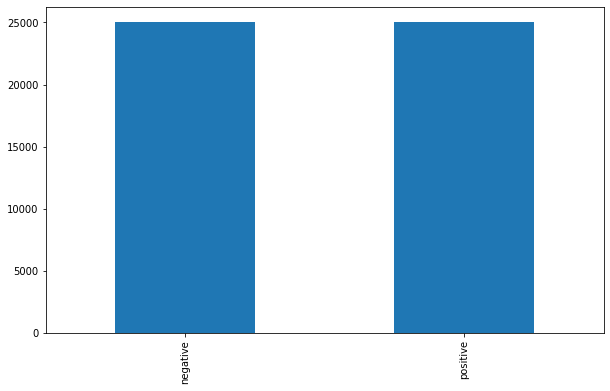

In [3]:
my_labels = ["positive", "negative"]
plt.figure(figsize = (10,6))
data["sentiment"].value_counts().plot(kind="bar")

So 2 labels are well balanced

II. Text pre-proccessing and splitting data

Let's take a closer look at couple of review to see what kinds of cleaning techniques we should consider to use for this dataset.

In [4]:
data["review"][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [5]:
data["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

For this dataset, we will use steps: remove stop words, change text to lower case, remove punctuation, remove bad characters, special characters, and so on.

    1. Preparation

In [6]:
#define regular expression into a pattern for later text cleansing
re1 = re.compile('[/(){}\[\]\|@,;]')
re2 = re.compile('[^0-9a-z #+_]')
re3 = set(stopwords.words('english'))
#define a function that take a string as parameter and return the cleaned text as the result
def clean_text(text):
    text = text.lower()
    text = re1.sub(" ", text)
    text = re2.sub(" ", text)
    text = " ".join(word for word in text.split() if word not in re3)
    return text

    2. Data Cleaning

In [7]:
data['review'] = data['review'].apply(clean_text)

Let's take a look at previous data we looked at

In [8]:
data["review"][0]

'one reviewers mentioned watching 1 oz episode hooked right exactly happened br br first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word br br called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away br br would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches d

In [9]:
data["review"][2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point 2 risk addiction thought proof woody allen still fully control style many us grown love br br laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman br br may crown jewel career wittier devil wears prada interesting superman great comedy go see friends'

It looked better and cleaner now.

In [10]:
data["review"].apply(lambda x: len(x.split(' '))).sum()

6183125

We only have 6,183,125 words left after removing stop words, and cleaning text.

    3.Data processing

In [11]:
X = data["review"]
y = data["sentiment"]
x_train, x_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 1)

III. Implement models

After splitting the dataset, we will convert our text review to a matrix of token counts (CounterVectorizer), then transform a count matrix to a normalized tf-idf representation(TfidfTransformer). Final step is train our classifier. Because the processes using CounterVectorizer and TfidfTransformer is the same for every model, we will apply Pipeline.

    1. Naive Bayes Classifier for Multinomial Models
We will start with Naive Bayes, which provides a baseline for this task.

In [12]:
nbmodel = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB()),])
nbmodel.fit(x_train, y_train)

y_pred = nbmodel.predict(x_test)

accuracyNB = accuracy_score(y_pred, y_test)

print(classification_report(y_test, y_pred,target_names=my_labels))
print(f"Naive Bayes Model's accuracy: {accuracyNB}")

              precision    recall  f1-score   support

    positive       0.87      0.88      0.87      5044
    negative       0.88      0.86      0.87      4956

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Naive Bayes Model's accuracy: 0.8709


We achieved 87% accuracy

    2. Linear Support Vector Machine

In [13]:
sgdmodel = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),])
sgdmodel.fit(x_train, y_train)

y_pred = sgdmodel.predict(x_test)

accuracy_sgd = accuracy_score(y_pred, y_test)

print(classification_report(y_test, y_pred,target_names=my_labels))
print(f"Linear Support Vector Machine's accuracy: {accuracy_sgd}")

              precision    recall  f1-score   support

    positive       0.91      0.78      0.84      5044
    negative       0.80      0.92      0.86      4956

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000

Linear Support Vector Machine's accuracy: 0.8504


We achieved 85% accuracy, 2% lower than Naive Bayes.
    3. Logistic Regression

In [14]:
logreg = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), 
                   ('clf', LogisticRegression(n_jobs=1, C=100, max_iter = 500)),])
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)

accuracy_log = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred,target_names=my_labels))
print(f"Logistic Regression's accuracy: {accuracy_log}")

              precision    recall  f1-score   support

    positive       0.90      0.89      0.89      5044
    negative       0.88      0.90      0.89      4956

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Logistic Regression's accuracy: 0.8924


The accuracy is 89% which is higher than both Naive Bayes and SVM.
With above simple linear model, we have achieved a high accuracy of 89%. In the next part, we will use the same dataset to fit in other advanced techniques such as word embedding (Word2Vec and Doc2vec) and neutral networks with keras.
    4. Word2vec and Logistic Regression

The principals behind Word2vec is using the surrounding words to represent the target words with a Neural Network whose hidden layer encodes the word representation.

First we will load word2vec model. It has been pre-trained by Google on a 100 billion word Google News corpus. You can download it from here: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

In [15]:
import gensim
wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", 
                                                     binary=True)
wv.init_sims(replace=True)

We will use average of two word vectors for BOW approach

In [16]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.vectors_norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)
#Warning for exceptional cases. If there is, those will be remove from the dataset.
    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

Next, we will tokenize the text then, apply to the "review" column and finally, apply word vector averaging to tokenized text.

In [17]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
train, test = train_test_split(data, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda data: w2v_tokenize_text(data['review']), axis=1).values
train_tokenized = train.apply(lambda data: w2v_tokenize_text(data['review']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

Now, we can fit the train data to our logistic model and see how it performs

In [18]:
logreg = LogisticRegression(n_jobs=1, C=1e5, max_iter = 300)
logreg = logreg.fit(X_train_word_average, train['sentiment'])
y_pred = logreg.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test['sentiment']))
print(classification_report(test['sentiment'], y_pred,target_names=my_labels))

accuracy 0.8562
              precision    recall  f1-score   support

    positive       0.85      0.85      0.85      7411
    negative       0.86      0.86      0.86      7589

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



It achives 85.62% accuracy. It is not really an impressing result. In fact, it is only a little higher than our linear classification. Let's try the Doc2vec.
    5. Doc2vec and Logistic Regression
The same idea of Word2vec is extended as instead of using surrounding words, now, we will consider using sentences or documents. There are times words can not capture so much meanings, we need relationship between sentences or documents.

In [20]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)
x_train = label_sentences(x_train, 'Train')
x_test = label_sentences(x_test, 'Test')
all_data = x_train + x_test

An example of tagged document in our "all_data"

In [21]:
all_data[:2]

[TaggedDocument(words=['pre', 'release', 'version', '1933', 'baby', 'face', 'would', 'make', 'ideal', 'introduction', 'corporate', 'seminar', 'sexual', 'harassment', 'mentored', 'nietszchean', 'professor', 'lily', 'powers', 'rises', 'life', 'easy', 'virtue', 'father', 'speakeasy', 'rapid', 'climb', 'corporate', 'ladder', 'large', 'bank', 'rung', 'ladder', 'executive', 'brain', 'belt', 'ethics', 'locked', 'vault', 'film', 'victims', 'except', 'lily', 'childhood', 'destroyed', 'abusive', 'exploitative', 'father', 'destructive', 'relationship', 'father', 'suggests', 'lily', 'hidden', 'motive', 'using', 'men', 'advance', 'without', 'regard', 'fate', 'lily', 'cynical', 'obvious', 'approach', 'men', 'targets', 'willingly', 'betray', 'wives', 'fianc', 'trade', 'jobs', 'sexual', 'favors', 'perhaps', 'bank', 'failures', '1930', 'owed', 'less', 'economics', 'morally', 'corrupt', 'executives', 'distracted', 'ambitious', 'women', 'br', 'br', 'plot', 'moves', 'fast', 'camera', 'amusingly', 'moves',

We will use these parameters for training our doc2vec model:
- dm=0 , distributed bag of words (DBOW) is used.
- vector_size=300 , 300 vector dimensional feature vectors.
- negative=5 , specifies how many “noise words” should be drawn.
- min_count=1, ignores all words with total frequency lower than this.
- alpha=0.065 , the initial learning rate.

We ill train the model for 30 epochs.

In [22]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from sklearn import utils

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

C:\Users\vucht\anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 50000/50000 [00:00<00:00, 1667715.31it/s]


Now, it is time to get vector from trained Doc2vec model

In [24]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(x_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(x_test), 300, 'Test')

Fit the data into the logistic model

In [25]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors_dbow, y_train)
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_labels))

accuracy 0.8854
              precision    recall  f1-score   support

    positive       0.89      0.88      0.89      7540
    negative       0.88      0.89      0.89      7460

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000



The accuracy is 0.88 which is higher in comparison to Word2vec.
    6. BOW with Keras
Last considered method is text classification with Keras - a deep learning library

In [26]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

#Seperate dataset into training and testing set
train_size = int(len(data) * .7)
train_posts = X[:train_size]
train_tags = y[:train_size]

test_posts = X[train_size:]
test_tags = y[train_size:]

#Compute the unique words and assign each of those words to indices. We also limit our vocabulary to 1000 of the most popular words.
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

#Create training data that will be fitted in the model.
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

#Encode labels
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 3

#Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

C:\Users\vucht\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\vucht\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\vucht\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\vucht\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi


Train on 31500 samples, validate on 3500 samples
Epoch 1/3
31500/31500 [==============================] - 15s 479us/step - loss: 0.3667 - accuracy: 0.8381 - val_loss: 0.3286 - val_accuracy: 0.8611
Epoch 2/3
31500/31500 [==============================] - 13s 427us/step - loss: 0.2839 - accuracy: 0.8810 - val_loss: 0.3274 - val_accuracy: 0.8614
Epoch 3/3
31500/31500 [==============================] - 12s 393us/step - loss: 0.2211 - accuracy: 0.9114 - val_loss: 0.3407 - val_accuracy: 0.8597


The accuracy of the model is

In [27]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

15000/15000 [==============================] - 1s 42us/step
Test accuracy: 0.8613333106040955


III.Conclusion

Below is the summary table of model and their classification accuracy

In [34]:
model_list = ["Naive Bayes Classifier for Multinomial Models","Linear Support Vector Machine", "Logistic Regression",
             "Word2vec and Logistic Regression", "Doc2vec and Logistic Regression", "BOW with keras"]
acc_list = [0.8709, 0.8504,0.8924, 0.8562, 0.8854, 0.8613]
conclusion = pd.DataFrame(acc_list, index = [model_list], columns = ["accuracy"]).sort_values("accuracy",ascending=False)
conclusion

,accuracy
Logistic Regression,0.8924
Doc2vec and Logistic Regression,0.8854
Naive Bayes Classifier for Multinomial Models,0.8709
BOW with keras,0.8613
Word2vec and Logistic Regression,0.8562
Linear Support Vector Machine,0.8504


As we can see Linear Support Vector Machine has the lowest accuracy (~85%) as expected due to its simplicity and Logistic Regression has the highest accuracy (89%). However, it is uncertain to claim which one is the best for text classification. There are different factors that affect the accuracy of each model that have not brought into consideration.